In [60]:
import tensorflow as tf
import numpy as np
from datetime import datetime
from resnet import SimpleResNetModule

tf.executing_eagerly = True

from matplotlib import pyplot as plt
%matplotlib inline

import scipy.stats as stats

In [64]:
class AutoEncoderModel(tf.keras.Model):
    """
    The model is set up as a small ResNet that is then
    funneled down to a single 2-unit dense layer, which is then 
    run through several dense layers to perform decoding.
    """
    
    def __init__(self,
                 encoder_hparams = [
                    {"filters": 4, "kernel_size": 3, "activation": "relu"},
                    {"filters": 4, "kernel_size": 3, "activation": "relu"},
                 ],
                 name = None):
        super().__init__(name = name)
        
        self.encoder_blocks = [SimpleResNetModule(hparams = hparams) for hparams in encoder_hparams]
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(2, activation = "linear")

        self.decoder_layers = [
            tf.keras.layers.Dense(16, activation = "relu"),
            tf.keras.layers.Dense(16, activation = "relu"),
            tf.keras.layers.Dense(10, activation = "softmax")
        ]
    
    def encode(self, x):
        for block in self.encoder_blocks:
            x = block(x)
        x = self.dense1(self.flatten(x))
        return x
    
    def call(self, x):
        x = self.encode(x)
        for block in self.decoder_layers:
            x = block(x)
        return x

In [65]:
model = AutoEncoderModel()
model.compile(
    run_eagerly=False,
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=1e-1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Fit the model 

In [66]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

model.fit(
    x = x_train,
    y = y_train,
    epochs = 3,
    batch_size = 32,
) 

Epoch 1/3
1875/1875 [==============================] - 29s 15ms/step - loss: 0.7578 - accuracy: 0.7439

In [67]:
print("Test accuracy: %.2f%%"%(tf.keras.metrics.Accuracy()(np.argmax(model(x_test), axis = 1), y_test).numpy()*100))

Test accuracy: 88.46%


# Plot encoding using learned parameters

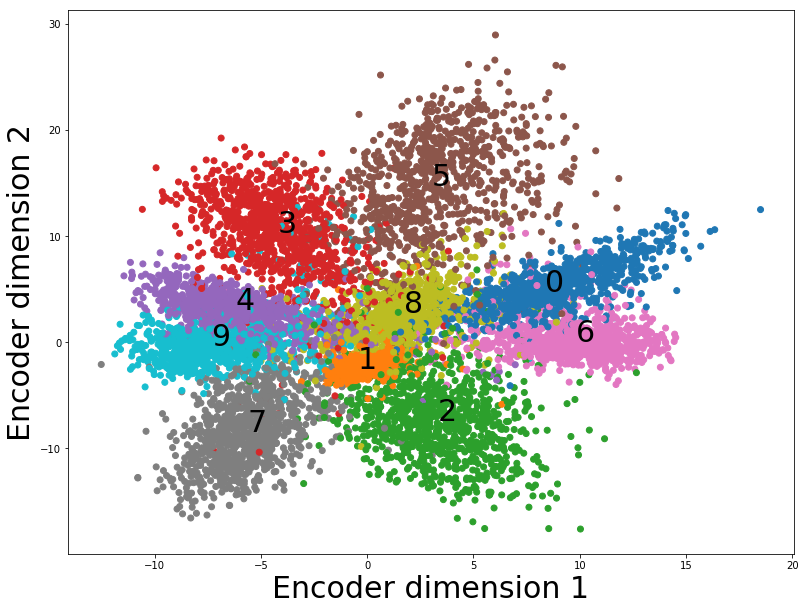

In [68]:
encoding = model.encode(x_test)
plt.figure(figsize=(13,10))
plt.scatter(encoding[:, 0], encoding[:, 1], c = y_test, cmap = "tab10", label = y_test)
plt.ylabel("Encoder dimension 2", fontsize = 30)
plt.xlabel("Encoder dimension 1", fontsize = 30)
for y in range(10):
    mu = np.median(encoding[y_test == y], axis = 0)
    plt.text(mu[0], mu[1], str(y), fontsize = 30)


